# Preprocessing
This notebook contains code to preprocess the dataset (problem solving, outlier handling, missing values etc.) and the feature creation.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Data Loading

In [90]:
# Loading data
df_train = pd.read_csv("../../data/train_data.csv")
df_test = pd.read_csv("../../data/test_data.csv")

C:\Users\Louis\AppData\Local\Temp\ipykernel_17912\3698058545.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("../../data/train_data.csv")


<span style="color:red">Todo copy to explo</span>

In [91]:
def prepare(df, date_columns=None, code_identifiers=['Code']):
    """
    Prepare the DataFrame by:
      - Converting specified date columns to datetime.
      - Casting columns with specified keywords (e.g., 'Code') in their names to categorical data type.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to prepare.
        date_columns (list): List of columns to convert to datetime. Default is None.
        code_identifiers (list): List of keywords to identify code columns. Default is ['Code'].
    
    Returns:
        pd.DataFrame: The modified DataFrame with date conversions and categorical castings applied.
    """
    # Convert specified columns to datetime
    if date_columns:
        for col in date_columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Convert code_identifiers to lowercase for case-insensitive matching
    code_identifiers = [keyword.lower() for keyword in code_identifiers]

    # Cast columns with keywords in their names to categorical
    for col in df.columns:
        if any(keyword in col.lower() for keyword in code_identifiers):
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].astype('category')
                print(f"Column '{col}' cast to 'category' data type.")
            else:
                print(f"Column '{col}' already non-numeric, no casting applied.")

    return df

In [92]:
# Define columns for date conversion
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']

# Prepare the training and test DataFrames
df_train = prepare(df_train, date_columns=date_columns)
df_test = prepare(df_test, date_columns=date_columns)

Column 'Industry Code' cast to 'category' data type.
Column 'Industry Code Description' already non-numeric, no casting applied.
Column 'WCIO Cause of Injury Code' cast to 'category' data type.
Column 'WCIO Nature of Injury Code' cast to 'category' data type.
Column 'WCIO Part Of Body Code' cast to 'category' data type.
Column 'Zip Code' already non-numeric, no casting applied.
Column 'Industry Code' cast to 'category' data type.
Column 'Industry Code Description' already non-numeric, no casting applied.
Column 'WCIO Cause of Injury Code' cast to 'category' data type.
Column 'WCIO Nature of Injury Code' cast to 'category' data type.
Column 'WCIO Part Of Body Code' cast to 'category' data type.
Column 'Zip Code' already non-numeric, no casting applied.


## Individual Feature Processing
- Unifying missing data with NaN
- Removing outliers
- etc.

Missing data will be handled in a later step (Imputer)

In [93]:
df_train.dtypes

Accident Date                         datetime64[ns]
Age at Injury                                float64
Alternative Dispute Resolution                object
Assembly Date                         datetime64[ns]
Attorney/Representative                       object
Average Weekly Wage                          float64
Birth Year                                   float64
C-2 Date                              datetime64[ns]
C-3 Date                              datetime64[ns]
Carrier Name                                  object
Carrier Type                                  object
Claim Identifier                               int64
Claim Injury Type                             object
County of Injury                              object
COVID-19 Indicator                            object
District Name                                 object
First Hearing Date                    datetime64[ns]
Gender                                        object
IME-4 Count                                  f

**Age at injury**:
Impossible age of 0 replace with missing value (NaN)

In [94]:
df_train['Age at Injury'] = df_train['Age at Injury'].replace(0, np.nan)
df_test['Age at Injury'] = df_test['Age at Injury'].replace(0, np.nan)

We consider any age below 14 or over 80 to be erroneous as it is not possible to be legally working at that age.

In [95]:
df_train = df_train.drop(df_train[(df_train['Age at Injury'] < 14) | (df_train['Age at Injury'] > 80)].index)

**Birth year**: Impossible birth year of 0 replace with missing value (NaN)

In [96]:
df_train['Birth Year'] = df_train['Birth Year'].replace(0, np.nan)

**Carrier type**: Replace UNKNOWN with NaN to be handled by the imputer.

In [97]:
# Replace UNKNOWN with Nan
df_train['Carrier Type'] = df_train['Carrier Type'].replace("UNKNOWN", np.nan)
df_test['Carrier Type'] = df_test['Carrier Type'].replace("UNKNOWN", np.nan)

**Attorney representation**: Replace Y/N Strings with boolean.

In [98]:
# Replace 'Y' with True, 'N' with False, and preserve NaNs
df_train['Attorney/Representative'] = df_train['Attorney/Representative'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_train['Attorney/Representative'] = df_train['Attorney/Representative'].astype("boolean")

In [99]:
# Replace 'Y' with True, 'N' with False, and preserve NaNs
df_test['Attorney/Representative'] = df_test['Attorney/Representative'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_test['Attorney/Representative'] = df_test['Attorney/Representative'].astype("boolean")

C:\Users\Louis\AppData\Local\Temp\ipykernel_17912\3794846623.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Attorney/Representative'] = df_test['Attorney/Representative'].replace({'Y': True, 'N': False})


**Alternative Dispute Resolution**: Replace Y/N Strings with boolean and Unknown with NaN to be handled by imputer.

In [100]:
df_train['Alternative Dispute Resolution'] = df_train['Alternative Dispute Resolution'].replace("U", np.nan)

In [101]:
df_train['Alternative Dispute Resolution'] = df_train['Alternative Dispute Resolution'].replace({'Y': True, 'N': False})
df_train['Alternative Dispute Resolution'] = df_train['Alternative Dispute Resolution'].astype("boolean")

In [102]:
df_test['Alternative Dispute Resolution'] = df_test['Alternative Dispute Resolution'].replace("U", np.nan)
df_test['Alternative Dispute Resolution'] = df_test['Alternative Dispute Resolution'].replace({'Y': True, 'N': False})
df_test['Alternative Dispute Resolution'] = df_test['Alternative Dispute Resolution'].astype("boolean")

**Carrier Name**: Too many names - high dimensionality feature

In [103]:
# Replace unknowns with "others"?
# Will be treated in New Features Section

**Claim Identifier**: Contains duplicates - is the ID column of the dataset

In [104]:
# Completely remove duplicates in "Claim Identifier" from train
df_train = df_train[~df_train['Claim Identifier'].duplicated(keep=False)]

**IME-4 Count**: Outlier handling - Anything over 10 is considered extreme/high as seen in exploratory analysis

In [105]:
# Cap high values to 10
lower_bound = 0
upper_bound = 10
df_train['IME-4 Count'] = df_train['IME-4 Count'].apply(lambda x: min(max(x, lower_bound), upper_bound))

**Covid indicator**: Replace Y/N Strings with boolean

In [106]:
df_train['COVID-19 Indicator'] = df_train['COVID-19 Indicator'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_train['COVID-19 Indicator'] = df_train['COVID-19 Indicator'].astype("boolean")

df_test['COVID-19 Indicator'] = df_test['COVID-19 Indicator'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_test['COVID-19 Indicator'] = df_test['COVID-19 Indicator'].astype("boolean")

C:\Users\Louis\AppData\Local\Temp\ipykernel_17912\1821571298.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['COVID-19 Indicator'] = df_test['COVID-19 Indicator'].replace({'Y': True, 'N': False})


**Average Weekly Wage**: Outlier handling - anything over 30'000 is considered extreme/high as seen exploratory analysis

In [107]:
upper_bound = 3.0e+04
lower_bound = 0
df_train['Average Weekly Wage'] = df_train['Average Weekly Wage'].apply(lambda x: min(max(x, lower_bound), upper_bound))

**Medical Fee Region**: Replace Unknown with NaN to be handled by Imputer

In [108]:
df_train['Medical Fee Region'] = df_train['Medical Fee Region'].replace("UK", np.nan)
df_test['Medical Fee Region'] = df_test['Medical Fee Region'].replace("UK", np.nan)

**WCIO Part Of Body Code**: Treat negative numerical codes by applying absolute function

In [109]:
# Temporarily convert to numeric to apply absolute value, then convert back to category
df_train["WCIO Part Of Body Code"] = pd.to_numeric(df_train["WCIO Part Of Body Code"], errors='coerce').abs().astype('category')
df_test["WCIO Part Of Body Code"] = pd.to_numeric(df_test["WCIO Part Of Body Code"], errors='coerce').abs().astype('category')

print("Converted all 'WCIO Part Of Body Code' values to positive and restored as categorical.")

Converted all 'WCIO Part Of Body Code' values to positive and restored as categorical.


**Zip Code**: Setting placeholder ZIP codes as NaN to be treated by imputer.

In [110]:
# Replace placeholder values with NaN in the original DataFrame
df_train.loc[df_train["Zip Code"].str.match(r'^0+$', na=False), "Zip Code"] = np.nan
print("Replaced placeholder values with NaN in 'Zip Code'.")

Replaced placeholder values with NaN in 'Zip Code'.


**Gender**: Replace unknown with NaN to be treated by imputer.

In [111]:
# Replace unknown with NaN
df_train['Gender'] = df_train['Gender'].replace("U", np.nan)
df_test['Gender'] = df_test['Gender'].replace("U", np.nan)

## Feature removal
Some features are useless as they're either not filled, have no variation or not present in the test dataset.

In [112]:
# Function to display percentage distribution of values in a column if it exists
def display_value_percentages(df, column_name):
    if column_name in df.columns:
        percentages = df[column_name].value_counts(normalize=True) * 100
        print(f"Percentage distribution in '{column_name}' - {df.name}:")
        print(percentages)
        print("\n")
    else:
        print(f"Column '{column_name}' does not exist in {df.name}.\n")

# Assign names to the dataframes for display purposes
df_train.name = 'df_train'
df_test.name = 'df_test'

**Feature OIICS Nature of Injury Description** is empty both in train and test

In [113]:
# Check and display/drop "OIICS Nature of Injury Description" in df_train and df_test
display_value_percentages(df_train, 'OIICS Nature of Injury Description')
display_value_percentages(df_test, 'OIICS Nature of Injury Description')

Percentage distribution in 'OIICS Nature of Injury Description' - df_train:
Series([], Name: proportion, dtype: float64)


Percentage distribution in 'OIICS Nature of Injury Description' - df_test:
Series([], Name: proportion, dtype: float64)




In [114]:
df_train = df_train.drop(['OIICS Nature of Injury Description'], axis=1, errors='ignore')
df_test = df_test.drop(['OIICS Nature of Injury Description'], axis=1, errors='ignore')

**Feature WCB Decision** is empty in test dataset.

In [115]:
# Assign names to the dataframes for display purposes
df_train.name = 'df_train'
df_test.name = 'df_test'
# Check and display/drop "WCB Decision" in df_train and df_test
display_value_percentages(df_train, 'WCB Decision')
display_value_percentages(df_test, 'WCB Decision')

Percentage distribution in 'WCB Decision' - df_train:
WCB Decision
Not Work Related    100.0
Name: proportion, dtype: float64


Column 'WCB Decision' does not exist in df_test.



In [116]:
df_train = df_train.drop(['WCB Decision'], axis=1, errors='ignore')
df_test = df_test.drop(['WCB Decision'], axis=1, errors='ignore')

**Feature Agreement Reached** is empty in test dataset.

- This could be a secondary target variable. As of 06.11.2024: We drop this column.

In [117]:
# Assign names to the dataframes for display purposes
df_train.name = 'df_train'
df_test.name = 'df_test'
# Check and display/drop "Agreement Reached" in df_train and df_test
display_value_percentages(df_train, 'Agreement Reached')
display_value_percentages(df_test, 'Agreement Reached')

Percentage distribution in 'Agreement Reached' - df_train:
Agreement Reached
0.0    95.335562
1.0     4.664438
Name: proportion, dtype: float64


Column 'Agreement Reached' does not exist in df_test.



In [118]:
df_train = df_train.drop(['Agreement Reached'], axis=1, errors='ignore')
df_test = df_test.drop(['Agreement Reached'], axis=1, errors='ignore')

## Row Removal
Some rows can be dropped due to missing values in the target variable. NaN will never be a possible target category as it is invalid.

In [119]:
df_train["Claim Injury Type"].unique()

array(['2. NON-COMP', '4. TEMPORARY', nan, '3. MED ONLY',
       '5. PPD SCH LOSS', '6. PPD NSL', '1. CANCELLED', '8. DEATH',
       '7. PTD'], dtype=object)

In [120]:
#Remove rows where the target variable is NaN
df_train.dropna(axis = 0 , subset=["Claim Injury Type"],inplace = True)

## Splitting Data

In [121]:
# Will be done in model

## Imputing Missing Data

In [122]:
# Will be done in modeL

## Feature Creation

**Accident date SPLIT**: Transform to four new features (day, month, year, weekday)

- Why? E.g. Weekday vs weekend might impact decision as weekend is likely not work related

In [124]:
# Extract accident year, month, day, and day of week for train
df_train['Accident Year'] = df_train['Accident Date'].dt.year
df_train['Accident Month'] = df_train['Accident Date'].dt.month
df_train['Accident Day'] = df_train['Accident Date'].dt.day
df_train['Accident DayOfWeek'] = df_train['Accident Date'].dt.dayofweek

# Extract accident year, month, day, and day of week for test
df_test['Accident Year'] = df_test['Accident Date'].dt.year
df_test['Accident Month'] = df_test['Accident Date'].dt.month
df_test['Accident Day'] = df_test['Accident Date'].dt.day
df_test['Accident DayOfWeek'] = df_test['Accident Date'].dt.dayofweek

**All Dates**: Days passed since accident

- Why? We assume this holds predictive power and is easier to interpret for the model.

In [125]:
def add_days_since_accident(df, accident_date_col='Accident Date', date_columns=None):
    """
    Add new columns to the DataFrame representing days since the accident date for each specified date column.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the date columns.
        accident_date_col (str): The column name for the accident date.
        date_columns (list): List of date columns to calculate days since accident for. Accident date itself will be excluded.

    Returns:
        pd.DataFrame: The DataFrame with new 'Days Since Accident' columns added.
    """
    if date_columns is None:
        date_columns = []
    
    for col in date_columns:
        if col != accident_date_col:
            dsa_col = f"{col} DSA"
            df[dsa_col] = (df[col] - df[accident_date_col]).dt.days
            print(f"Column '{dsa_col}' created to represent days since '{accident_date_col}'.")

    return df

In [126]:
df_train = add_days_since_accident(df_train, accident_date_col='Accident Date', date_columns=date_columns)
df_test = add_days_since_accident(df_test, accident_date_col='Accident Date', date_columns=date_columns)

Column 'Assembly Date DSA' created to represent days since 'Accident Date'.
Column 'C-2 Date DSA' created to represent days since 'Accident Date'.
Column 'C-3 Date DSA' created to represent days since 'Accident Date'.
Column 'First Hearing Date DSA' created to represent days since 'Accident Date'.
Column 'Assembly Date DSA' created to represent days since 'Accident Date'.
Column 'C-2 Date DSA' created to represent days since 'Accident Date'.
Column 'C-3 Date DSA' created to represent days since 'Accident Date'.
Column 'First Hearing Date DSA' created to represent days since 'Accident Date'.


**Age Category** - Split age into groups

- Why? To give model a categorical feature for age.

In [128]:
# Define age category mapping
age_bins = [0, 19, 25, 40, 60, 120]  # Age ranges
age_labels = ['Teen', 'Young Adult', 'Adult', 'Middle-Aged', 'Senior']  # Category labels
age_column = 'Age at Injury'

# Create 'Age At Injury Category' based on bins
df_train['Age at Injury Category'] = pd.cut(df_train[age_column], bins=age_bins, labels=age_labels, right=False)
df_test['Age at Injury Category'] = pd.cut(df_test[age_column], bins=age_bins, labels=age_labels, right=False)

**Carrier Name** - Claim Category

- To indicate if Carrier has a lot of claims, medium amount or low amount of them.
- Why? Easier to interpret for the model than 2000 categories

<span style="color:red">TODO move to explo</span>

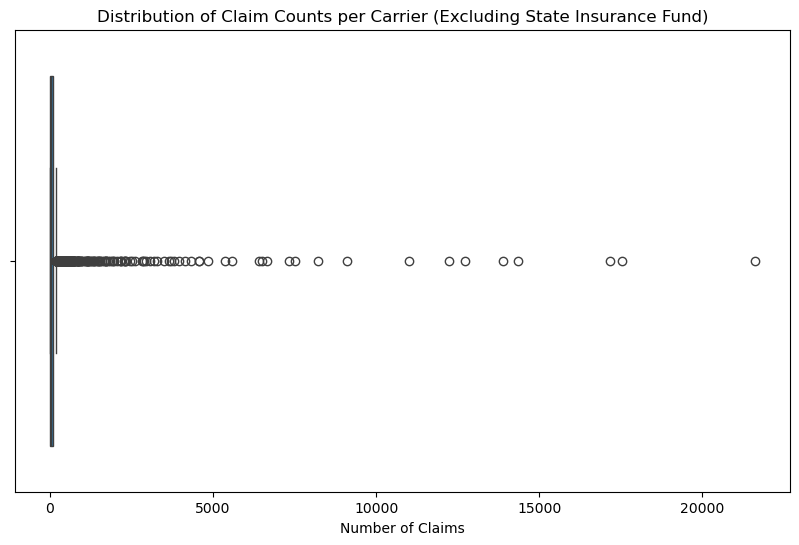

In [129]:
# Count the number of claims per carrier
carrier_counts = df_train['Carrier Name'].value_counts()

# Exclude "State Insurance Fund"
carrier_counts = carrier_counts[carrier_counts.index != 'STATE INSURANCE FUND']

# Plotting the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=carrier_counts)
plt.title('Distribution of Claim Counts per Carrier (Excluding State Insurance Fund)')
plt.xlabel('Number of Claims')
plt.show()

Decision:
- Category HIGH for State Fund
- Category MEDIUM for 5k to 50k claims
- Category LOW for 5k and below claims

In [131]:
# Calculate the claim counts per carrier
carrier_counts = df_train['Carrier Name'].value_counts()

# Define a function to categorize each carrier based on its claim count
def categorize_claims(count):
    if count >= 50000:
        return 'HIGH'
    elif 5000 <= count < 50000:
        return 'MEDIUM'
    else:
        return 'LOW'

# Apply the categorization to create a mapping dictionary
carrier_category_map = carrier_counts.apply(categorize_claims)

# Map the `Carrier Name` in the original DataFrame to the new `Carrier Claim Category`
df_train['Carrier Claim Category'] = df_train['Carrier Name'].map(carrier_category_map)

In [132]:
# Display the first few rows to verify
df_train[['Carrier Name', 'Carrier Claim Category']].head()

,Carrier Name,Carrier Claim Category
0,NEW HAMPSHIRE INSURANCE CO,MEDIUM
1,ZURICH AMERICAN INSURANCE CO,LOW
2,INDEMNITY INSURANCE CO OF,MEDIUM
4,STATE INSURANCE FUND,HIGH
5,INDEMNITY INS. OF N AMERICA,MEDIUM


**WCIO Part Of Body Code** - Group Body Sections/Regions

Creating a map to map codes to section (body region)

- Based on https://www.iaiabc.org/standard-references -> https://assets.noviams.com/novi-file-uploads/iaiabc/EDI_Documents/WCIO_InjuryDescriptionTableandHistory-4dadd33c.xls
- The table contains different sub codes such as 14 -> "head" and 14A -> "IAIABC". Our dataset only has numerical codes, we will therefore only use purely numerical codes from the excel for the map.

In [133]:
# Load the 'Part' sheet from the Excel file
file_path = '../../data/WCIO_InjuryDescriptionTableandHistory-4dadd33c.xlsx'
df_part = pd.read_excel(file_path, sheet_name='Part')

In [134]:
# Filter rows to include only those with purely numerical codes or ranges
numeric_rows = df_part[df_part['Code'].astype(str).str.match(r'^\d+(-\d+)?$')]

# Dictionary to store each code's Body Section
code_to_section_mapping = {}

for _, row in numeric_rows.dropna(subset=['Code', 'Section']).iterrows():
    code = row['Code']
    section = row['Section']
    
    # If the code is a range like "10-23", expand it and map each number in the range
    if '-' in str(code):
        start, end = map(int, code.split('-'))
        for i in range(start, end + 1):
            # Map each code in the range to its section
            code_to_section_mapping[float(i)] = section
    else:
        # For individual numeric codes, map them directly
        numeric_code = float(code)
        code_to_section_mapping[numeric_code] = section

In [135]:
code_to_section_mapping

{1.0: 'Unassigned',
 2.0: 'Unassigned',
 3.0: 'Unassigned',
 4.0: 'Unassigned',
 5.0: 'Unassigned',
 6.0: 'Unassigned',
 7.0: 'Unassigned',
 8.0: 'Unassigned',
 9.0: 'Unassigned',
 10.0: 'Head',
 11.0: 'Head',
 12.0: 'Head',
 13.0: 'Head',
 14.0: 'Head',
 15.0: 'Head',
 16.0: 'Head',
 17.0: 'Head',
 18.0: 'Head',
 19.0: 'Head',
 20.0: 'Neck',
 21.0: 'Neck',
 22.0: 'Neck',
 23.0: 'Neck',
 24.0: 'Neck',
 25.0: 'Neck',
 26.0: 'Neck',
 27.0: 'Unassigned',
 28.0: 'Unassigned',
 29.0: 'Unassigned',
 30.0: 'Upper Extremities',
 31.0: 'Upper Extremities',
 32.0: 'Upper Extremities',
 33.0: 'Upper Extremities',
 34.0: 'Upper Extremities',
 35.0: 'Upper Extremities',
 36.0: 'Upper Extremities',
 37.0: 'Upper Extremities',
 38.0: 'Upper Extremities',
 39.0: 'Upper Extremities',
 40.0: 'Trunk',
 41.0: 'Trunk',
 42.0: 'Trunk',
 43.0: 'Trunk',
 44.0: 'Trunk',
 45.0: 'Trunk',
 46.0: 'Trunk',
 47.0: 'Trunk',
 48.0: 'Trunk',
 49.0: 'Trunk',
 60.0: 'Trunk',
 61.0: 'Trunk',
 62.0: 'Trunk',
 63.0: 'Trunk'

In [136]:
# Apply to df_train
df_train["Body Section"] = df_train["WCIO Part Of Body Code"].map(code_to_section_mapping)
df_train["Body Section"] = df_train["Body Section"].fillna("Unassigned")
# Apply to df_test
df_test["Body Section"] = df_test["WCIO Part Of Body Code"].map(code_to_section_mapping)
df_test["Body Section"] = df_test["Body Section"].fillna("Unassigned")

Quality Checks

In [137]:
# Optional: Display the resulting DataFrame to confirm the new feature
df_train[["Body Section","WCIO Part Of Body Code","WCIO Part Of Body Description"]].head()

,Body Section,WCIO Part Of Body Code,WCIO Part Of Body Description
0,Trunk,62.0,BUTTOCKS
1,Upper Extremities,38.0,SHOULDER(S)
2,Head,10.0,MULTIPLE HEAD INJURY
4,Upper Extremities,36.0,FINGER(S)
5,Upper Extremities,38.0,SHOULDER(S)


In [138]:
df_train["WCIO Part Of Body Description"].unique()

array(['BUTTOCKS', 'SHOULDER(S)', 'MULTIPLE HEAD INJURY', 'FINGER(S)',
       'LUNGS', 'EYE(S)', 'ANKLE', 'KNEE', 'THUMB', 'LOWER BACK AREA',
       'ABDOMEN INCLUDING GROIN', 'LOWER LEG', 'HIP', 'UPPER LEG',
       'MOUTH', 'WRIST', 'SPINAL CORD', 'HAND', 'SOFT TISSUE',
       'UPPER ARM', 'FOOT', 'ELBOW', 'MULTIPLE UPPER EXTREMITIES',
       'MULTIPLE BODY PARTS (INCLUDING BODY',
       'BODY SYSTEMS AND MULTIPLE BODY SYSTEMS', 'MULTIPLE NECK INJURY',
       'CHEST', 'WRIST (S) & HAND(S)', 'EAR(S)',
       'MULTIPLE LOWER EXTREMITIES', 'DISC', 'LOWER ARM', 'MULTIPLE',
       'UPPER BACK AREA', 'SKULL', 'TOES', 'FACIAL BONES', nan, 'TEETH',
       'NO PHYSICAL INJURY', 'MULTIPLE TRUNK', 'WHOLE BODY',
       'INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED', 'PELVIS',
       'NOSE', 'GREAT TOE', 'INTERNAL ORGANS', 'HEART', 'VERTEBRAE',
       'LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA', 'BRAIN',
       'SACRUM AND COCCYX', 'ARTIFICIAL APPLIANCE', 'LARYNX', 'TRACHEA'],
      dtype=ob

In [139]:
df_train["Body Section"].value_counts()

Body Section
Upper Extremities      178178
Lower Extremities      120040
Trunk                  101123
Unassigned              59032
Head                    56727
Multiple Body Parts     46179
Neck                    11909
Name: count, dtype: int64

# Save enriched DF

In [140]:
# Save the enriched DataFrames with "_enriched" added to the filenames
df_train.to_csv("../../data/train_data_enriched.csv", index=False)
df_test.to_csv("../../data/test_data_enriched.csv", index=False)